In [1]:
import tensorflow as tf

from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.platform import gfile

import functools

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, pickle

import str_ww_util as util
import get_dataset
import keras_model as models

from IPython import display

In [2]:
rng = np.random.default_rng(2024)

In [3]:
from get_dataset import decode_audio, get_label, get_waveform_and_label, \
                        convert_labels_str2int, convert_to_int16, cast_and_pad, \
                        convert_dataset, get_preprocess_audio_func, prepare_background_data, \
                        get_training_data, count_labels, is_batched

In [4]:
Flags, unparsed = util.parse_command()

In [5]:
# Flags.num_train_samples = 100
# Flags.num_val_samples = 100
# Flags.num_test_samples = 100

load_pretrained_model = False # True to load from a file, False to build/train from scratch
pretrained_model_path = 'trained_models/ref_model.h5'
pretrained_model_path = 'trained_models/str_ww_model.h5'

# Flags.data_dir = os.path.join(os.getenv('HOME'), 'data', 'speech_commands_files_0.2')
Flags.data_dir = os.path.join(os.getenv('HOME'), 'data', 'speech_commands_v2')
 
Flags.bg_path = Flags.data_dir
Flags.epochs = 2

get_waves = False

BACKGROUND_NOISE_DIR_NAME='_background_noise_' 
background_data = prepare_background_data(Flags.bg_path,BACKGROUND_NOISE_DIR_NAME)



In [13]:
# ds_train, ds_test, ds_val = get_training_data(Flags)

label_count=3
background_frequency = Flags.background_frequency
background_volume_range_= Flags.background_volume
model_settings = models.prepare_model_settings(label_count, Flags)

In [14]:
ds_train, ds_test, ds_val = get_dataset.get_training_data(Flags)


In [15]:
for dat in ds_train.unbatch().take(1):
  print("One element from the training set has shape:")
  print(f"Input tensor shape: {dat[0].shape}")
  print(f"Label shape: {dat[1].shape}")
  print(f"Label : {dat[1]}")
  break



One element from the training set has shape:
Input tensor shape: (49, 40)
Label shape: ()
Label : 2


In [16]:
# create a tmp dataset with only the target words
# ds_only_target = ds_train.filter(lambda dat: dat['label'] == 0)
# print("Five elements from the only-target set:")
# for dat in ds_only_target.take(5):
#   print(f"Input tensor shape: {dat['audio'].shape}")  
#   print(f"Label = {dat['label']}; shape = {dat['label'].shape}")


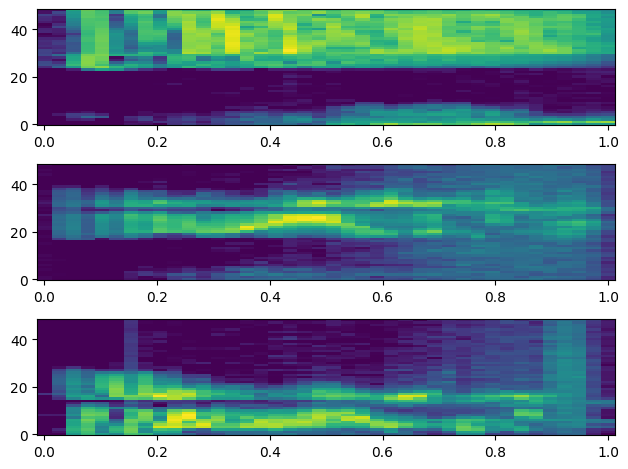

In [17]:
max_target_examples = 3
target_count = 0
target = tf.constant(0)
plt.Figure(figsize=(10,4))
for dat in ds_train.unbatch():
  # label_string = dat[1].numpy().decode('utf8')
  if dat[1] == target:
    target_count += 1
    ax = plt.subplot(max_target_examples, 1, target_count)
    # display.display(display.Audio(dat[0].numpy(), rate=16000))

    log_spec = dat[0].numpy()
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, 1.0, num=width, dtype=float)
    Y = range(height)
    ax.pcolormesh(X, Y, np.squeeze(log_spec))
    if target_count >= max_target_examples:
      break
plt.tight_layout()

In [18]:
## look at the label breakdown in the training set
# print(count_labels(ds_train))

## current count_labels is very slow.  some scratch code here towards
## implementing a faster one by converting labels to one-hot and then summing.
# tf.one_hot(indices, depth)
# ds_1hot = ds_train.map(lambda dat: tf.one_hot(dat[1], 3))
# xx = iter(ds_1hot).next()


## Build and Train Model

In [19]:
# during development, to reload the models module w/o restarting the kernel
# import importlib
# importlib.reload(models)

In [20]:
if load_pretrained_model:
  print(f"Loading pretrained model from {pretrained_model_path}")
  model = keras.models.load_model(pretrained_model_path)
else:
  print(f"Building model from scratch")
  model = models.get_model(args=Flags) # compile step is done inside get_model()

Building model from scratch
DS TCN model for streaming invoked


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 40)]          0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 49, 1, 40)        0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 45, 1, 40)        200       
 Conv2D)                                                         
                                                                 
 conv2d (Conv2D)             (None, 45, 1, 128)        5120      
                                                                 
 batch_normalization (BatchN  (None, 45, 1, 128)       512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 45, 1, 128)        0     

In [25]:
if not load_pretrained_model:
  callbacks = util.get_callbacks(args=Flags)
  train_hist = model.fit(ds_train, validation_data=ds_val, callbacks=callbacks,
                         epochs=Flags.epochs)


Epoch 1: LearningRateScheduler setting learning rate to 0.0005.
Epoch 1/2
1034/1034 [==============================] - 167s 157ms/step - loss: 0.3208 - sparse_categorical_accuracy: 0.9043 - val_loss: 16.0347 - val_sparse_categorical_accuracy: 3.0057e-04 - lr: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005.
Epoch 2/2
1034/1034 [==============================] - 138s 134ms/step - loss: 0.2916 - sparse_categorical_accuracy: 0.9145 - val_loss: 18.1249 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 5.0000e-04


In [27]:
save_model = True
if save_model:
  model.save('trained_models/streaming_ww_model_float.h5')

In [ ]:
if not load_pretrained_model:
  plt.subplot(2,1,1)
  plt.semilogy(train_hist.epoch, train_hist.history['loss'], train_hist.history['val_loss'])
  plt.legend(['training', 'validation'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.subplot(2,1,2)
  plt.plot(train_hist.epoch, train_hist.history['sparse_categorical_accuracy'], train_hist.history['val_sparse_categorical_accuracy'])
  plt.legend(['training', 'validation'])
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')


In [ ]:
model.evaluate(ds_val)

In [ ]:
label_list = ['marvin', 'silent', 'other']
model_out = model.predict(ds_val)
y_pred_val = np.argmax(model_out, axis=1)

y_true_val = np.nan*np.zeros(y_pred_val.shape[0])
for i,dat in enumerate(ds_val.unbatch()):
  y_true_val[i] = dat[1]

acc = sum(y_pred_val == y_true_val) / len(y_true_val)
print(f'Validation set accuracy: {acc:.1%}')

In [ ]:
ds_train = ds_train.unbatch().batch(1)

In [ ]:

confusion_mtx = tf.math.confusion_matrix(y_true_val, y_pred_val) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Scratch Space


In [ ]:
preproc_func = get_preprocess_audio_func(model_settings,is_training=True,
                                         background_data=background_data)

test_wav = rng.normal(size=(16000,1))
proc_wav_dict = preproc_func({'audio':example_wav, 'label':1})
                        

In [ ]:
# tf.squeeze
# proc_wav_dict['audio']

In [ ]:
for dat in ds_only_target.take(1):
  next_element = dat
is_training = True


desired_samples = model_settings['desired_samples']
background_frequency = model_settings['background_frequency']
background_volume_range_= model_settings['background_volume_range_']

wav_decoder = tf.cast(next_element['audio'], tf.float32)
if model_settings['feature_type'] != "td_samples":
  wav_decoder = wav_decoder/tf.reduce_max(wav_decoder)
else:
  wav_decoder = wav_decoder/tf.constant(2**15,dtype=tf.float32)
#Previously, decode_wav was used with desired_samples as the length of array. The
# default option of this function was to pad zeros if the desired samples are not found
wav_decoder = tf.pad(wav_decoder,[[0,desired_samples-tf.shape(wav_decoder)[-1]]]) 
# Allow the audio sample's volume to be adjusted.
foreground_volume_placeholder_ = tf.constant(1,dtype=tf.float32)

scaled_foreground = tf.multiply(wav_decoder,
                                foreground_volume_placeholder_)
# Shift the sample's start position, and pad any gaps with zeros.
time_shift_padding_placeholder_ = tf.constant([[2,2]], tf.int32)
time_shift_offset_placeholder_ = tf.constant([2],tf.int32)
scaled_foreground.shape
padded_foreground = tf.pad(scaled_foreground, time_shift_padding_placeholder_, mode='CONSTANT')
sliced_foreground = tf.slice(padded_foreground, time_shift_offset_placeholder_, [desired_samples])

if is_training and background_data != []:
  background_volume_range = tf.constant(background_volume_range_,dtype=tf.float32)
  background_index = np.random.randint(len(background_data))
  background_samples = background_data[background_index]
  background_offset = np.random.randint(0, len(background_samples) - desired_samples)
  background_clipped = background_samples[background_offset:(background_offset + desired_samples)]
  background_clipped = tf.squeeze(background_clipped)
  background_reshaped = tf.pad(background_clipped,[[0,desired_samples-tf.shape(wav_decoder)[-1]]])
  background_reshaped = tf.cast(background_reshaped, tf.float32)
  if np.random.uniform(0, 1) < background_frequency:
    background_volume = np.random.uniform(0, background_volume_range_)
  else:
    background_volume = 0
  background_volume_placeholder_ = tf.constant(background_volume,dtype=tf.float32)
  background_data_placeholder_ = background_reshaped
  background_mul = tf.multiply(background_data_placeholder_,
                       background_volume_placeholder_)
  background_add = tf.add(background_mul, sliced_foreground)
  sliced_foreground = tf.clip_by_value(background_add, -1.0, 1.0)

# apply preemphasis
preemphasis_coef = 1 - 2 ** -5
power_offset = 52
num_mel_bins = model_settings['dct_coefficient_count']
paddings = tf.constant([[0, 0], [1, 0]])
# for some reason, tf.pad only works with the extra batch dimension, but then we remove it after pad
sliced_foreground = tf.expand_dims(sliced_foreground, 0)
sliced_foreground = tf.pad(tensor=sliced_foreground, paddings=paddings, mode='CONSTANT')
sliced_foreground = sliced_foreground[:, 1:] - preemphasis_coef * sliced_foreground[:, :-1]
sliced_foreground = tf.squeeze(sliced_foreground) 
# compute fft
stfts = tf.signal.stft(sliced_foreground,  frame_length=model_settings['window_size_samples'], 
                       frame_step=model_settings['window_stride_samples'], fft_length=None,
                       window_fn=functools.partial(
                         tf.signal.hamming_window, periodic=False),
                       pad_end=False,
                       name='STFT')

# compute magnitude spectrum [batch_size, num_frames, NFFT]
magspec = tf.abs(stfts)
num_spectrogram_bins = magspec.shape[-1]

# compute power spectrum [num_frames, NFFT]
powspec = (1 / model_settings['window_size_samples']) * tf.square(magspec)
powspec_max = tf.reduce_max(input_tensor=powspec)
powspec = tf.clip_by_value(powspec, 1e-30, powspec_max) # prevent -infinity on log

def log10(x):
  # Compute log base 10 on the tensorflow graph.
  # x is a tensor.  returns log10(x) as a tensor
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

# Warp the linear-scale, magnitude spectrograms into the mel-scale.
lower_edge_hertz, upper_edge_hertz = 0.0, model_settings['sample_rate'] / 2.0
linear_to_mel_weight_matrix = (
    tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=model_settings['sample_rate'],
        lower_edge_hertz=lower_edge_hertz,
        upper_edge_hertz=upper_edge_hertz))
print(f"After powspec, shape = {powspec.shape}")

mel_spectrograms = tf.tensordot(powspec, linear_to_mel_weight_matrix,1)
print(f"After lin2mel, mel_spec shape = {log_mel_spec.shape}")

mel_spectrograms.set_shape(magspec.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))
print(f"After set_shape mel_spectrograms, shape = {mel_spectrograms.shape}")

log_mel_spec = 10 * log10(mel_spectrograms)
# log_mel_spec = tf.expand_dims(log_mel_spec, -1, name="mel_spec")

log_mel_spec = (log_mel_spec + power_offset - 32 + 32.0) / 64.0
log_mel_spec = tf.clip_by_value(log_mel_spec, 0, 1)
print(f"After log_mel_spec, shape = {log_mel_spec.shape}")
next_element['audio'] = log_mel_spec  
